# SOM 60x40: Room Occupancy

All Jupyter Notebooks are published at the following link: [https://github.com/landgrafb98/SOM_22_Coding_Topic_G_Demo_DataCombo-3](https://github.com/landgrafb98/SOM_22_Coding_Topic_G_Demo_DataCombo-3).

In [41]:
import sys
sys.path.append("C:/Users/bene9/PycharmProjects/SOM_22_Coding_Topic_G_Demo_DataCombo-3/venv2/Lib/site-packages/PySOMVis")
from PySOMVis.pysomvis import PySOMVis
from PySOMVis.minisom import MiniSom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import holoviews as hv
from scipy.ndimage import zoom
import math

# Data Exploration

In [2]:
# Load the dataset
data = pd.read_csv("datasets/Occupancy_Estimation.csv")

# Inspect the dataset
print(data.info())  # Display columns and types
print(data.head())  # Display first few rows

# Identify target, time and features
target = data["Room_Occupancy_Count"]
time = data[["Date", "Time"]]
features = data.drop(columns=["Room_Occupancy_Count", "Date", "Time"])

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled = pd.DataFrame(features_scaled, columns=features.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

In [3]:
# Check for missing values
print("Missing values per column:")
print(data.isnull().sum())

Missing values per column:
Date                    0
Time                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64


In [4]:
# Summarize numerical features
print("Numerical feature summary:")
print(features.describe())

Numerical feature summary:
            S1_Temp       S2_Temp       S3_Temp       S4_Temp      S1_Light  \
count  10129.000000  10129.000000  10129.000000  10129.000000  10129.000000   
mean      25.454012     25.546059     25.056621     25.754125     25.445059   
std        0.351351      0.586325      0.427283      0.356434     51.011264   
min       24.940000     24.750000     24.440000     24.940000      0.000000   
25%       25.190000     25.190000     24.690000     25.440000      0.000000   
50%       25.380000     25.380000     24.940000     25.750000      0.000000   
75%       25.630000     25.630000     25.380000     26.000000     12.000000   
max       26.380000     29.000000     26.190000     26.560000    165.000000   

          S2_Light      S3_Light      S4_Light      S1_Sound      S2_Sound  \
count  10129.00000  10129.000000  10129.000000  10129.000000  10129.000000   
mean      26.01629     34.248494     13.220259      0.168178      0.120066   
std       67.30417     58.4

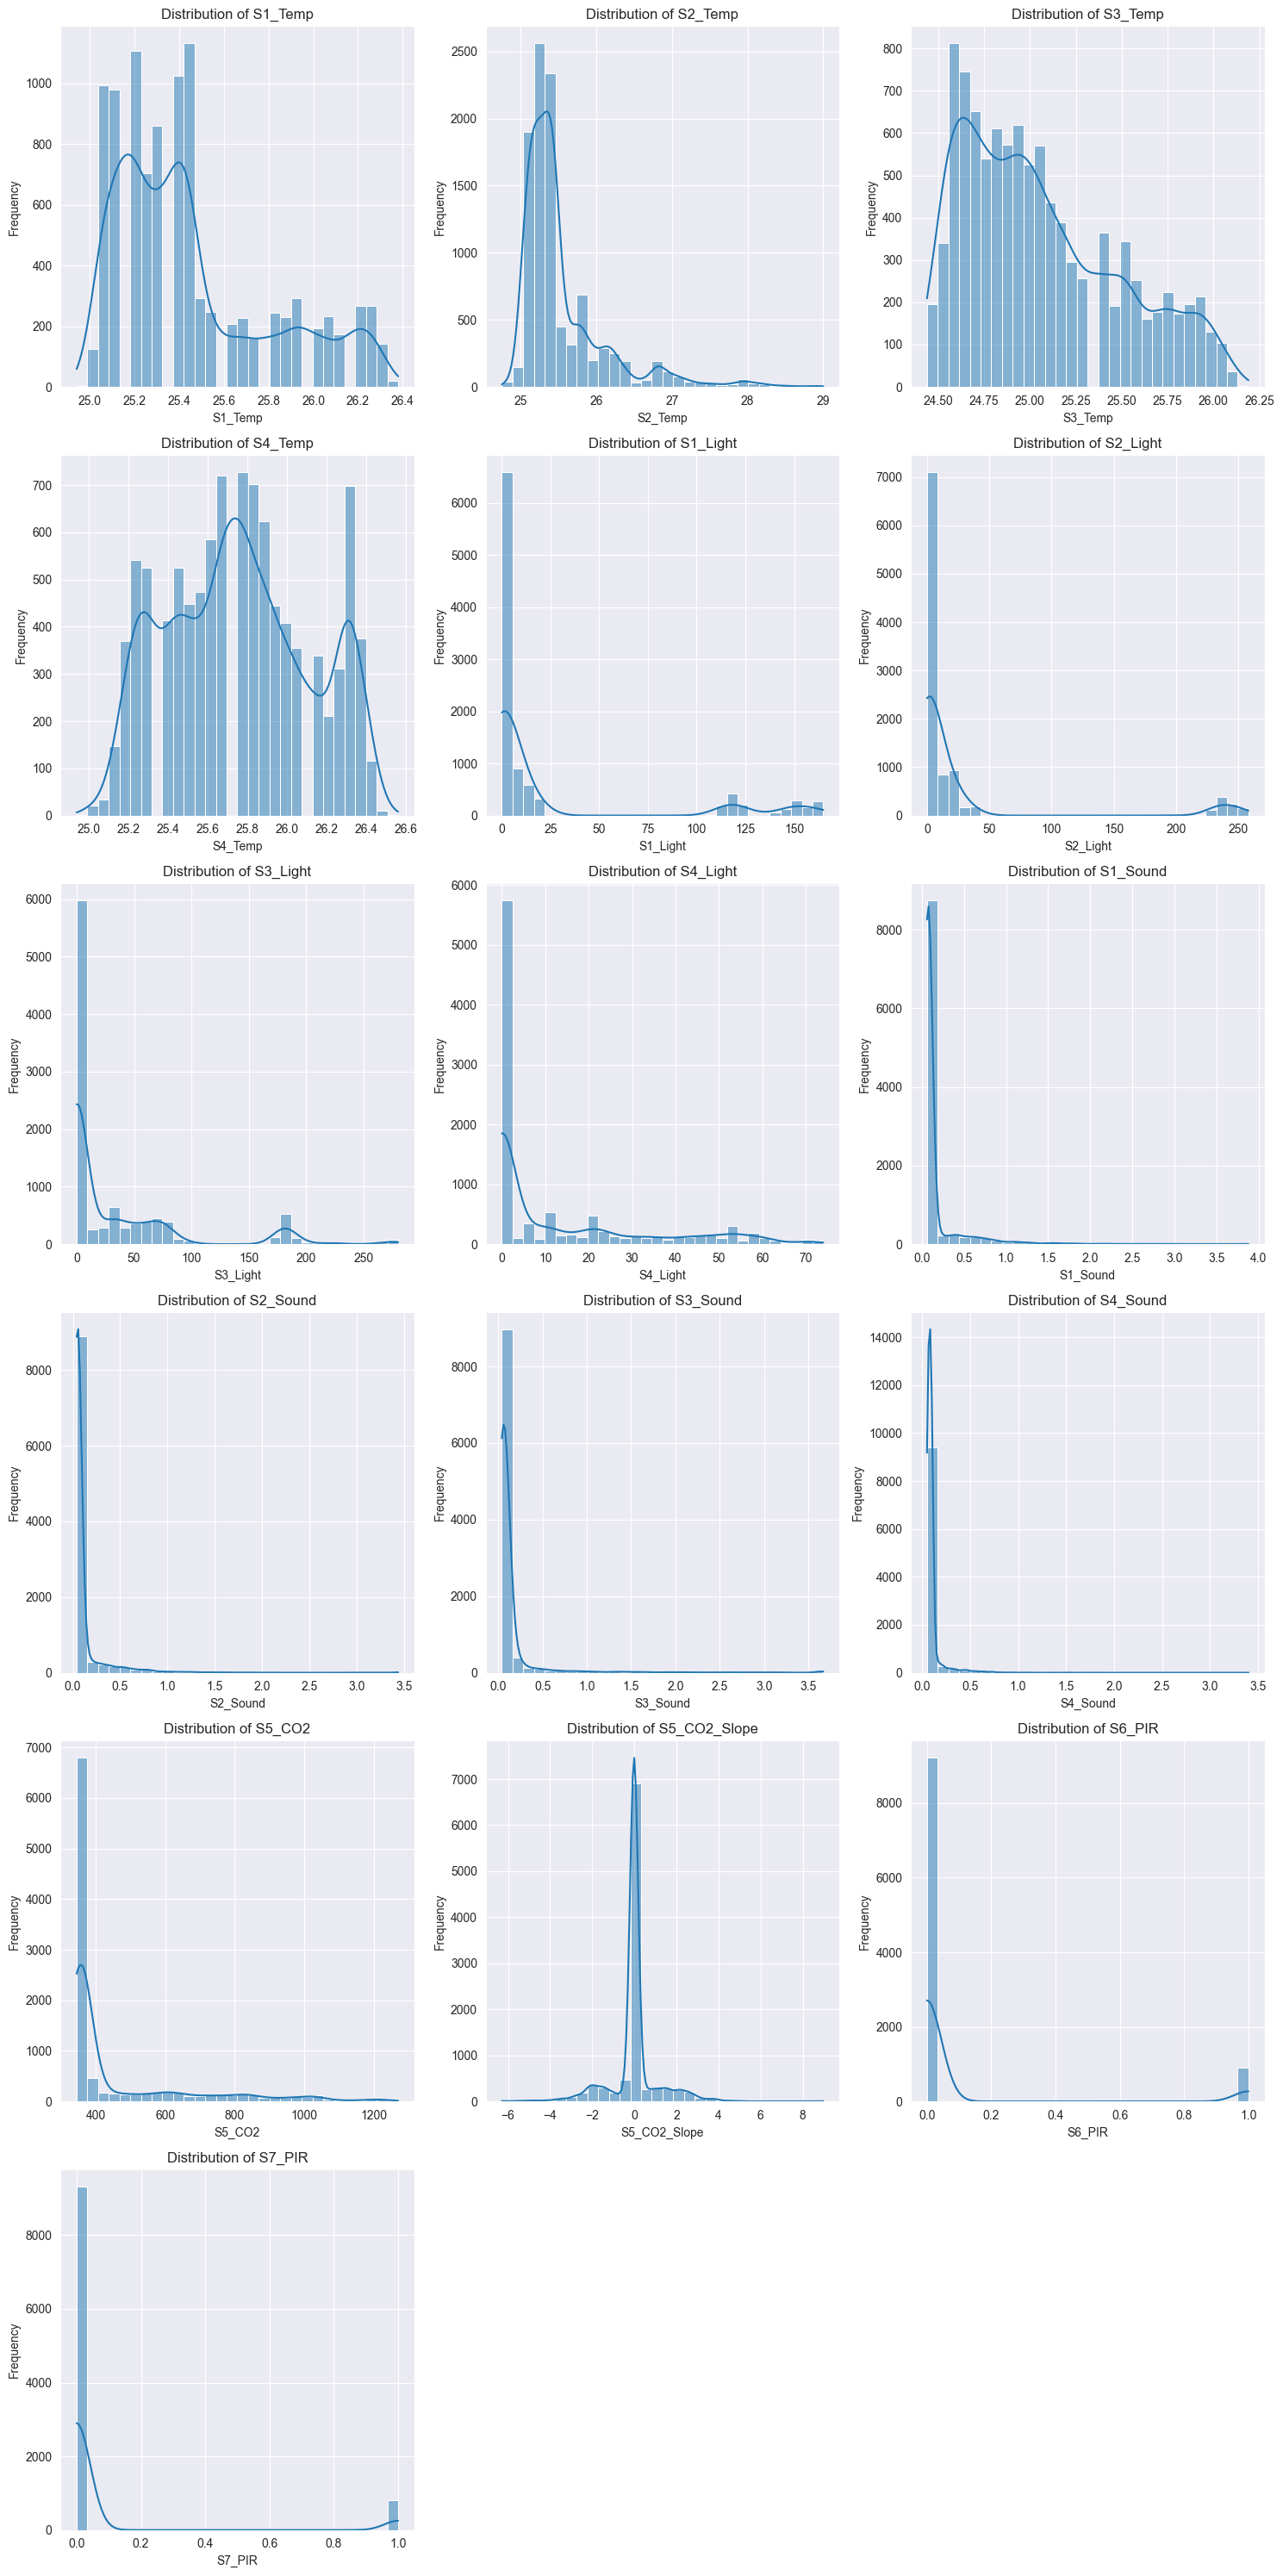

In [42]:
# Determine the number of columns
num_cols = len(features.columns)

# Calculate the number of rows and columns for subplots
num_rows = math.ceil(num_cols / 3)  # 3 columns per row

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Convert to 1D array for easier iteration

for i, column in enumerate(features.columns):
    sns.histplot(features[column], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f"Distribution of {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Frequency")

# Remove unnecessary subplots if needed
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

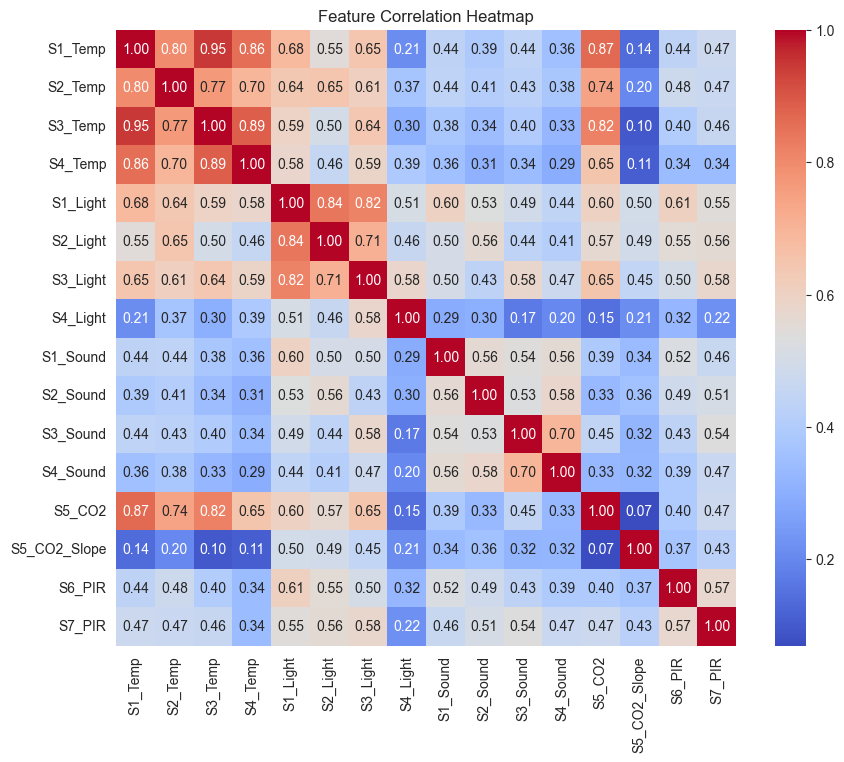

In [6]:
# Check correlations between numerical features
correlation_matrix = features.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

When we look at the correlation matrix, we see some features that are strongly correlated with each other. These should be removed before training a SOM. Therefore, features that have a correlation greater than 0.85 with another feature are removed.

In [7]:
# Identify features to drop
threshold = 0.85
to_drop = set()
for i in correlation_matrix.columns:
    if i not in to_drop:
        for j in correlation_matrix.columns:
            if i != j and abs(correlation_matrix.loc[i, j]) > threshold and j not in to_drop:
                to_drop.add(j)

# Drop the redundant features
features_scaled_reduced = features_scaled.drop(columns=list(to_drop))
features_reduced = features.drop(columns=list(to_drop))
print(to_drop)

{'S5_CO2', 'S4_Temp', 'S3_Temp'}


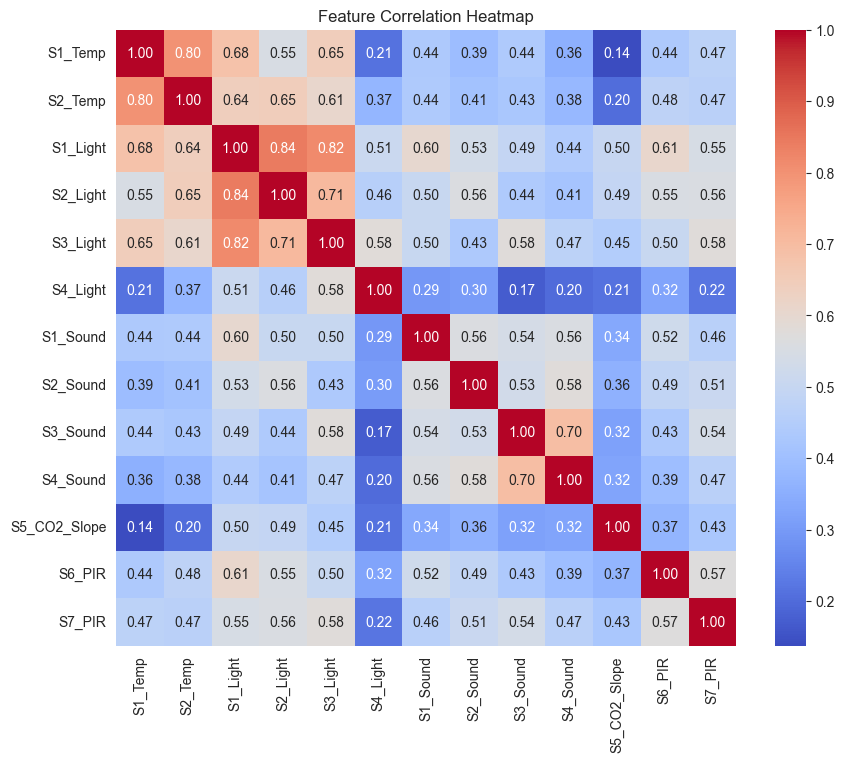

In [8]:
corr_matrix_reduced = features_reduced.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_reduced, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# SOM

First, the SOM is trained with dimensions of 60x40. For this, the minisom library is used, which is included in PySOMVis.

In [9]:
# Train the SOM
som = MiniSom(x=60, y=40, input_len=features_scaled_reduced.shape[1], sigma=1.0, learning_rate=0.5)
som.train(features_scaled_reduced.values, num_iteration=1000)

Next, the interactive visualization from PySOMVis is generated. This includes all visualizations from the library and is primarily used to verify the accuracy of the subsequent custom visualizations. The code used to create the custom visualizations is based on the code from PySOMVis.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
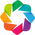

Column
    [0] Column
        [0] Column
            [0] Row(margin=(5, 10), width=700)
                [0] StaticText(value='<b></b>')
                [1] Select(options=OrderedDict([('Component P...]), value=0)
                [2] Select(options=OrderedDict([('PiYG', ...]), value='jet')
                [3] Button(name='↶')
                [4] Button(name='↷')
                [5] Button(name='↔')
                [6] Button(name='↕')
                [7] Checkbox(name='interpolation')
        [1] Row
            [0] Column
                [0] HoloViews(DynamicMap, height=500, sizing_mode='fixed', width=500)
            [1] Row
                [0] Column
                    [0] Column(margin=(5, 10), name='Component Planes')
                        [0] StaticText(value='<b>Component Planes</b>')
                        [1] IntSlider(end=12, name='Component')
                    [1] Str(str)
    [1] Column
        [0] Row()

In [11]:
hv.extension('bokeh')
som_vis = PySOMVis(weights=som.get_weights(), input_data=features_scaled_reduced.values, classes=target.values)
som_vis._mainview

## Density

### Hit Histogram

A Hit Histogram in the context of Self-Organizing Maps (SOMs) is a visualization that shows how often data points are assigned to specific nodes in the SOM grid. Each node in the grid represents a prototype vector, which summarizes the characteristics of the data points closest to it. In a hit histogram, the "hits" reflect the number of data points mapped to a particular node, with color intensity representing the hit count. Bright or warm colors (e.g., red) indicate many hits, while dark or cool colors (e.g., blue) indicate fewer or no hits. This visualization provides insights into the distribution and density of data points across the feature space, helping to identify clusters, sparse regions, and potential outliers.

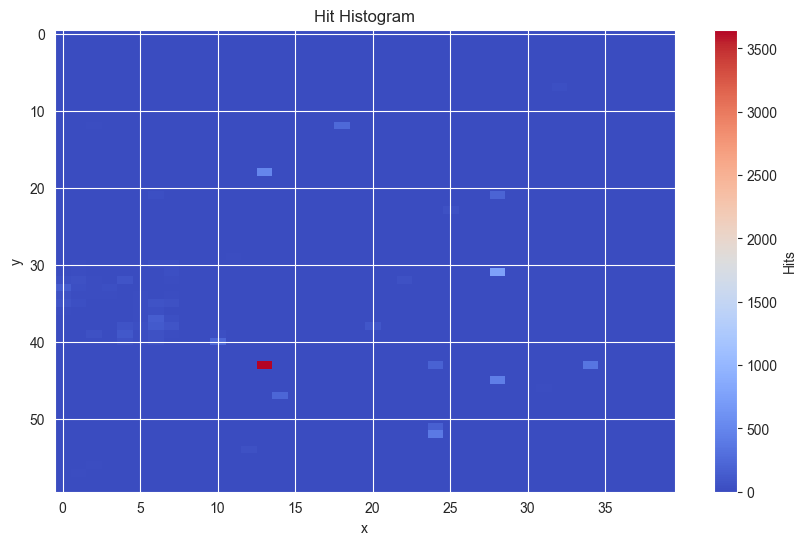

In [12]:
weights = som_vis._weights
input_data = som_vis._idata
m, n = som_vis._m, som_vis._n

hist = np.zeros(m * n)
for vector in input_data: 
    position = np.argmin(np.sqrt(np.sum(np.power(weights - vector, 2), axis=1)))
    hist[position] += 1

hit_hist_data = hist.reshape(m, n)

plt.figure(figsize=(10, 6))
plt.imshow(hit_hist_data, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Hits')
plt.title('Hit Histogram')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

This hit histogram reveals several important patterns. First, there is a high-density region with a bright red area, indicating a cluster of many data points. This suggests that this part of the SOM grid represents a common pattern or frequently occurring combination of features in the dataset. In contrast, large portions of the grid appear dark or lightly colored, indicating regions with very few or no hits. These sparse areas correspond to underrepresented or irrelevant parts of the feature space. Additionally, scattered hits in isolated regions of the grid may signify outliers or rare patterns within the data, as these points are distinct from the major clusters. The presence of multiple moderately hit regions further indicates that the dataset contains several clusters or groupings of similar data.

### Smoothed Data Histograms

An SDH (Smoothed Data Histogram) visualization is an advanced representation of how data points are distributed across the nodes of a Self-Organizing Map (SOM). Unlike a standard hit histogram that simply counts how many data points map to each node, an SDH smooths these counts by considering the influence of neighboring nodes. The level of smoothing is controlled by a factor (e.g., how many neighboring nodes are included in the computation). This provides a more nuanced view of the data distribution, reducing noise and highlighting general trends or patterns. There are 3 different approaches:
* Type 0 (Normalized Smoothing): Contributions are weighted by their rank (closer nodes contribute more than distant ones), normalized by the smooth factor.
* Type 1 (Distance-Based Smoothing): Contributions are weighted based on the inverse of the distance to the node.
* Type 2 (Min-Max Normalized Distance): Contributions are based on normalized distances within the closest nodes, emphasizing relative proximity.

In [15]:
def custom_sdh(factor, approach, ax=None):
    sdh = som_vis._visualizations[5]
    sdh_data = sdh.sdh(weights, m, n, input_data, factor, approach)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))  # Create figure only if no axis is provided
    
    im = ax.imshow(sdh_data, cmap='coolwarm', aspect='auto')
    ax.set_title(f'SDH: Factor {factor}, Approach {approach}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # Add colorbar only if a standalone figure was created
    if ax is None:
        plt.colorbar(im, ax=ax)
        plt.show()

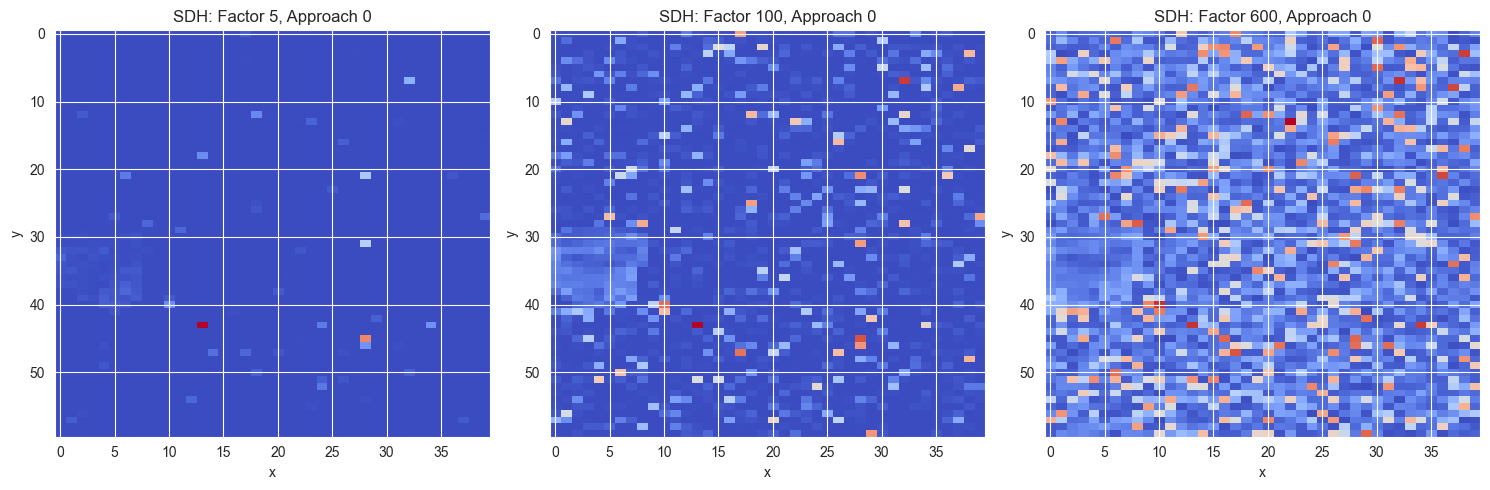

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create subplots

for ax, i in zip(axes, [5, 100, 600]):
    custom_sdh(i, 0, ax=ax)  # Pass each subplot to `custom_sdh`

plt.tight_layout()
plt.show()

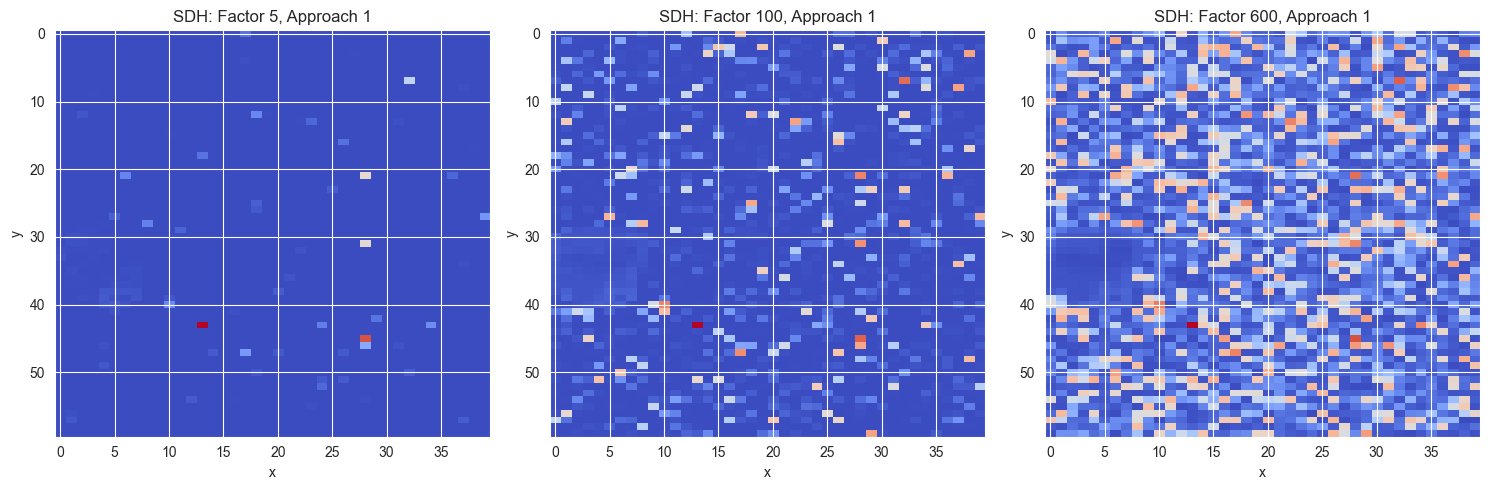

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create subplots

for ax, i in zip(axes, [5, 100, 600]):
    custom_sdh(i, 1, ax=ax)  # Pass each subplot to `custom_sdh`

plt.tight_layout()
plt.show()

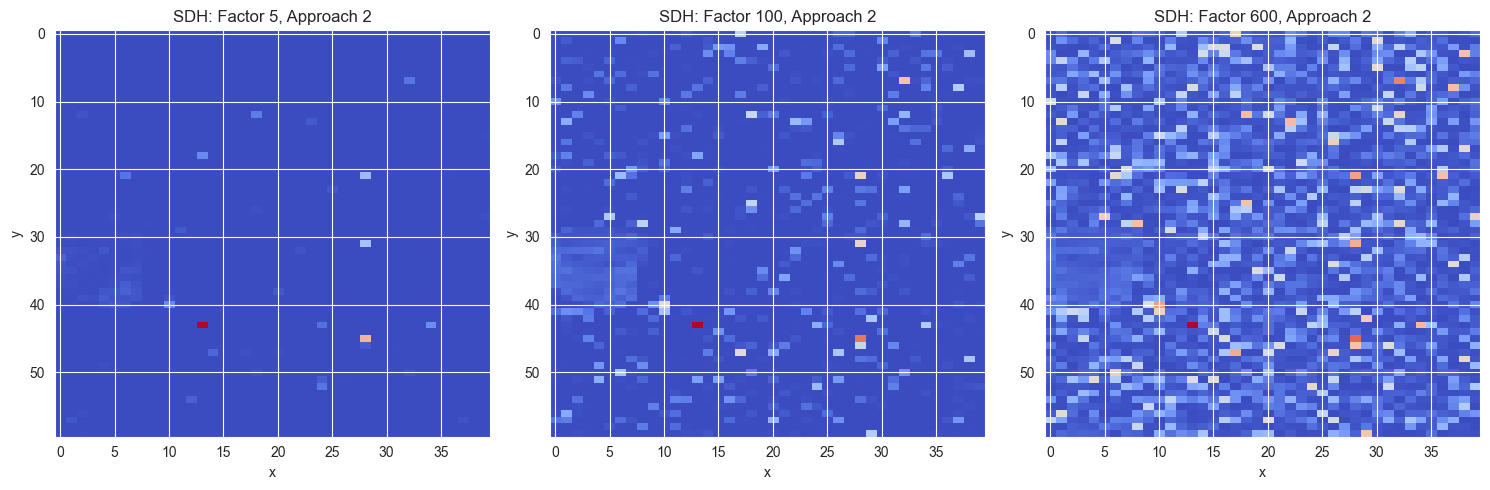

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create subplots

for ax, i in zip(axes, [5, 100, 600]):
    custom_sdh(i, 2, ax=ax)  # Pass each subplot to `custom_sdh`

plt.tight_layout()
plt.show()

* **Factor = 5**: This visualization shows a sharp and localized representation of the data distribution. Bright regions indicate nodes with high densities of data points, with minimal smoothing applied. The smaller smooth factor keeps the representation close to a standard hit histogram, emphasizing distinct clusters. However, the low factor also makes the visualization more sensitive to noise, leading to isolated high-intensity nodes rather than smooth transitions between clusters.
* **Factor = 100**: This visualization introduces more smoothing, which blends the influence of neighboring nodes over a broader area. Bright regions are still present, but the transitions between clusters are smoother, and smaller isolated areas of intensity are less pronounced. This level of smoothing provides a balance between preserving the sharpness of clusters and reducing noise.
* **Factor = 600**: With a high smooth factor, the visualization becomes highly generalized. Bright regions are less distinct, and the entire grid appears more blended, with broader zones of influence extending across the map. While specific clusters are harder to pinpoint, the overall distribution of data density becomes clearer. For example, the influence of the high-density regions from before spreads significantly into adjacent areas, emphasizing general trends over fine details.

### P-Matrix

The P-Matrix visualization is a method for analyzing the density of data points in the feature space around each node in a Self-Organizing Map (SOM). Instead of focusing solely on the direct hits or contributions (as with Hit Histograms or SDH), the P-Matrix considers a radius-based neighborhood around each SOM node and calculates how many data points fall within that radius.

In [19]:
def custom_p_matrix(radius_values):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Creates a 2x2 grid
    axes = axes.flatten()  # Flatten to easily iterate
    
    for i, radius in enumerate(radius_values):
        distance = lambda v: np.sum(np.linalg.norm(input_data[:, None, :] - v, axis=-1) < radius)
        p_matrix_data = np.array([distance(v) for v in weights])
        p_matrix_data = p_matrix_data.reshape(m, n)

        ax = axes[i]
        im = ax.imshow(p_matrix_data, cmap='coolwarm', aspect='auto')
        ax.set_title(f'P-Matrix: Radius {radius}')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        
        # Add colorbar to each subplot
        fig.colorbar(im, ax=ax)

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

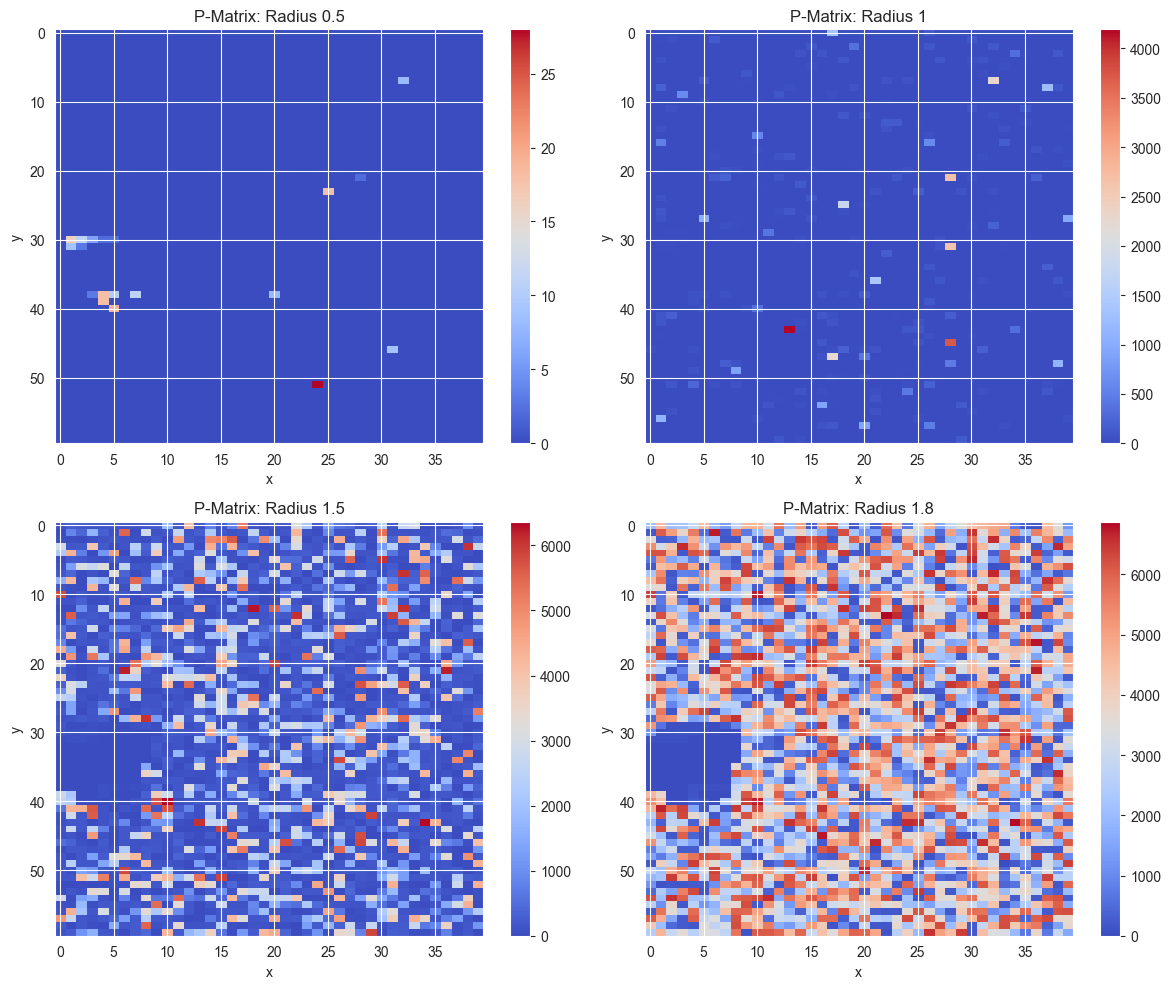

In [20]:
radius_list = [0.5, 1, 1.5, 1.8]
custom_p_matrix(radius_list)

* **Radius = 0.5**: In this visualization, the radius is very small, meaning the density is calculated for a tightly localized area around each node. As a result, the visualization is highly focused, with only a few nodes showing significant densities. The small radius highlights local density peaks without considering broader structures.
* **Radius = 1**: With a slightly larger radius, the density calculations now include a broader neighborhood around each node. More areas in the grid begin to show activity, and the influence of high-density clusters extends outward. Bright spots become more prominent, and more transitions between clusters are visible.
* **Radius = 1.5**:At this radius, the neighborhood effect becomes more pronounced, with a significant increase in the number of bright and moderate-density areas across the grid. Clusters begin to merge visually, as their influence overlaps due to the larger radius. Bright regions are now less distinct, and transitions between clusters become smoother.
* **Radius = 1.8**:With the largest radius in this series, the density calculations include the broadest neighborhoods, resulting in a highly generalized visualization. Almost every node on the grid has a significant density value, as the influence of high-density regions spreads widely. The grid becomes more uniform in appearance, and bright spots represent the most globally significant density regions.

### Sky Metaphor

The Sky Metaphor Visualization projects high-dimensional data onto a 2D plane, using an SDH (Smoothed Data Histogram) as the background to highlight density patterns, with bright areas indicating clusters and dark areas showing sparsity. Data points are positioned based on their proximity to SOM nodes and influenced by neighboring nodes, with the pull force controlling the balance between local and global influences. This visualization effectively reveals dense clusters, scattered patterns, and outliers, offering a clear view of the dataset's structure.

In [21]:
def normalize(values, actual_bounds, desired_bounds):
    return np.array([
        desired_bounds[0] + (x - actual_bounds[0]) * (desired_bounds[1] - desired_bounds[0]) / (actual_bounds[1] - actual_bounds[0])
        for x in values
    ])

def custom_sky_metaphor(factor, pull_force):
    sdh = som_vis._visualizations[5]
    sdh_data = sdh.sdh(weights, m, n, input_data, factor, 2)
    sdh_data = zoom(sdh_data, 20, order=2)
    
    points = np.empty((0, 2))
    k = 4
    for vector in input_data:
        dists = np.sqrt(np.sum(np.power(weights - vector, 2), axis=1))
        best_dists = np.argsort(dists)[:k]
        xy_points = np.array([[int(i % n), -1 * int(i / n) + m] for i in best_dists])
        u1, ui = xy_points[0], xy_points[1:]
        f = dists[best_dists[0]] / dists[best_dists[1:]]
        position = np.zeros(2, dtype="float64")
        for i in range(len(ui)):
            if (ui[i][0] - u1[0]) != 0:
                position[0] += f[i] * 1.0 / (ui[i][0] - u1[0])
            if (ui[i][1] - u1[1]) != 0:
                position[1] += f[i] * 1.0 / (ui[i][1] - u1[1])
        position = position * pull_force + u1
        points = np.vstack([points, position])
    
    points[:, 0] = normalize(points[:, 0], actual_bounds=[0, n], desired_bounds=[0, sdh_data.shape[1]])
    points[:, 1] = normalize(points[:, 1], actual_bounds=[0, m], desired_bounds=[0, sdh_data.shape[0]])
    
    plt.figure(figsize=(10, 6))
    plt.imshow(sdh_data, cmap='coolwarm', aspect='auto')
    plt.scatter(points[:, 0] * sdh_data.shape[1], points[:, 1] * sdh_data.shape[0],
                color='red', s=5, label='Projected Points')
    plt.colorbar(label='SDH Values')
    plt.title('Sky Metaphor Visualization: Factor:' + str(factor) + ", Pull Force:" + str(pull_force))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

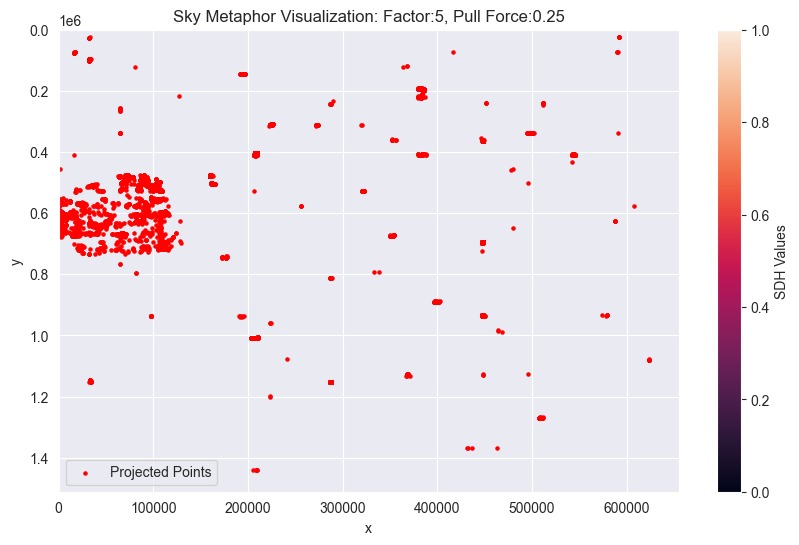

In [22]:
custom_sky_metaphor(5, 0.25)

A dense grouping of projected points is visible. This corresponds to a significant cluster in the data, as indicated by the high density of red points. The compact nature of this cluster suggests that the associated data points are very similar in terms of their features and are tightly grouped in the high-dimensional space. Outside the main cluster, the data points are scattered across the plane. These scattered points represent less frequent patterns or outliers in the dataset. Their positioning indicates weaker relationships with the primary cluster, and they are influenced by secondary nodes in the SOM. The distribution suggests a dataset with a dominant main cluster and several smaller, dispersed patterns.

### Neighborhood Graphs

## Distances

### Activity Histogram

An Activity Histogram visualizes the activation levels of all nodes in a Self-Organizing Map (SOM) for a specific data point. It shows how strongly each SOM node responds to the given data point by calculating the distance between the data point and the weight vector of each node. Smaller distances indicate higher similarity, meaning the node is more "activated" by the input data.

In [33]:
def custom_act_hist(vec_idx):
    vector = input_data[vec_idx]
    act_hist_data = np.linalg.norm(weights - vector, axis=1)
    act_hist_data = act_hist_data.reshape(m, n)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(act_hist_data, cmap='coolwarm', aspect='auto')
    plt.colorbar(label='Activation Level')
    plt.title(f'Activity Histogram for Vector Index {vec_idx}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

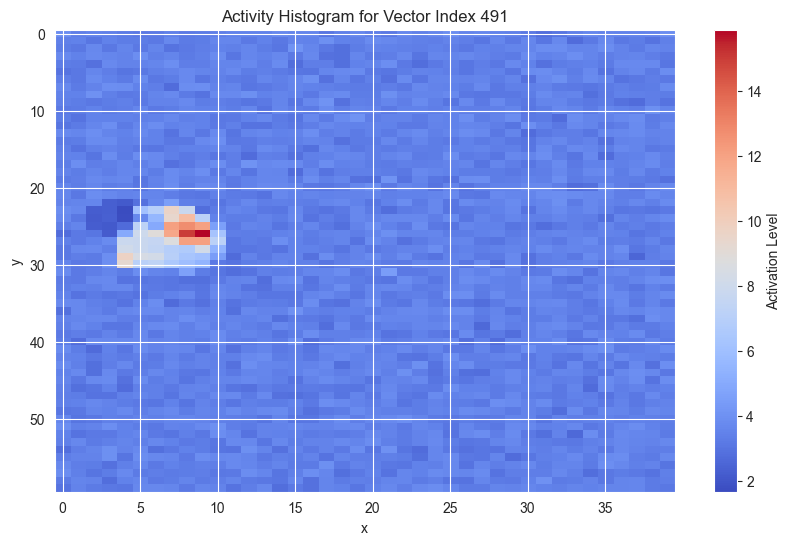

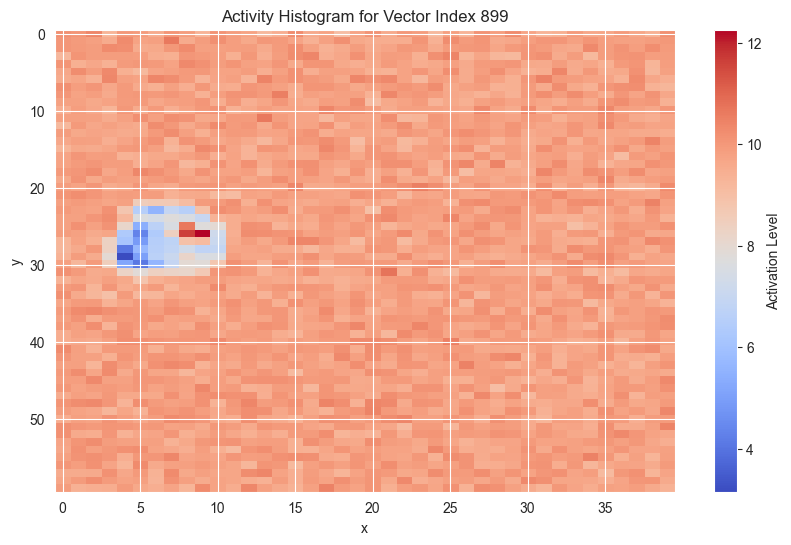

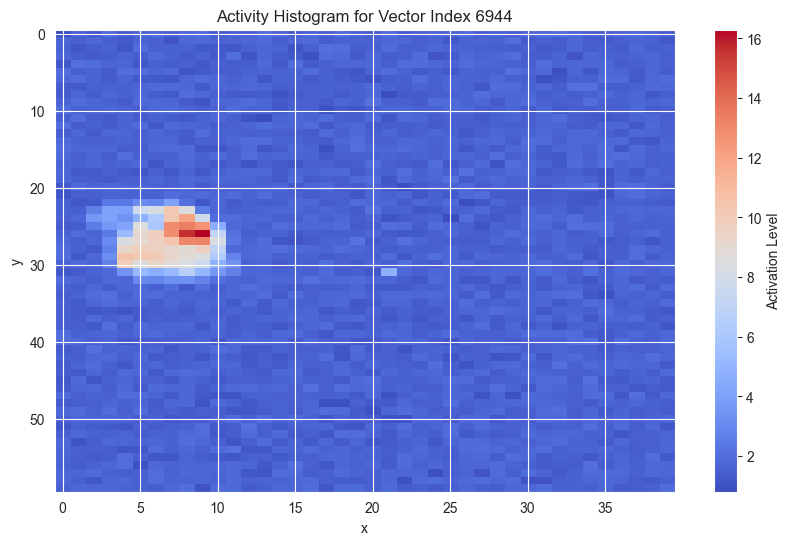

In [36]:
for i in [491, 899, 6944]:
    custom_act_hist(i)

* **Vector = 491**: For Vector 491, the activation is highly concentrated around one region, with only minor influence on surrounding nodes. This indicates that the SOM recognizes this vector as a strong match to a particular node or cluster. The localized red region suggests that Vector 491 belongs to a well-defined cluster, and its features align closely with the prototype of the best-matching unit (BMU) in this area of the map.
* **Vector = 899**: The widespread red activation across the SOM for Vector 899 indicates that this vector does not match any specific node or cluster well. Instead, it activates a broad range of nodes with relatively high distances, suggesting that it could be an outlier or have features that are not well-represented by the SOM. This behavior implies that the SOM has not learned a specific pattern for this vector, possibly due to insufficient training data similar to it or because it contains ambiguous or mixed features. This makes Vector 899 less distinct and difficult to assign to a particular cluster or region.
* **Vector = 6944**: The activation pattern for Vector 6944 is nearly identical to that of Vector 491, with a localized red region and minimal activation elsewhere. This indicates that Vector 6944 is also a part of the same cluster as Vector 491. The slight spread in activation compared to Vector 491 may suggest that Vector 6944 is slightly less similar to the BMU in this region, but it still fits well within the same cluster.

### Minimum Spanning Trees

### Cluster Connection

The Cluster Connection Visualization is used to explore the relationships between nodes in a Self-Organizing Map (SOM) based on their weight distances. The distances between neighboring SOM nodes are calculated, representing how similar or dissimilar their weights are. These distances are then visualized as connections (lines) between nodes, with the thickness or opacity of the lines indicating the strength of the connection.

In [25]:
def calculate_paths(weights, m, n):
    paths = []
    for y in range(m):
        for x in range(n):
            n1 = np.ravel_multi_index((y, x), dims=(m, n))
            if x < n - 1:
                n2 = np.ravel_multi_index((y, x + 1), dims=(m, n))
                w = np.linalg.norm(weights[n1] - weights[n2])
                paths.append([x, y, x + 1, y, w])
            if y < m - 1:
                n2 = np.ravel_multi_index((y + 1, x), dims=(m, n))
                w = np.linalg.norm(weights[n1] - weights[n2])
                paths.append([x, y, x, y + 1, w])
    paths_df = pd.DataFrame(paths, columns=['x0', 'y0', 'x1', 'y1', 'alpha'])
    return paths_df

paths = calculate_paths(weights, m, n)

def custom_cluster_connection(t1, t2, t3):    
    t1_mask = paths['alpha'] < t1
    t2_mask = (paths['alpha'] >= t1) & (paths['alpha'] < t2)
    t3_mask = (paths['alpha'] >= t2) & (paths['alpha'] < t3)

    plt.figure(figsize=(10, 6))
    plt.title(f"Cluster Connection: T1={t1}, T2={t2}, T3={t3}")

    plt.plot(
        [paths.loc[t1_mask, 'x0'], paths.loc[t1_mask, 'x1']],
        [paths.loc[t1_mask, 'y0'], paths.loc[t1_mask, 'y1']],
        color='black', alpha=1.0, linewidth=1.5
    )

    plt.plot(
        [paths.loc[t2_mask, 'x0'], paths.loc[t2_mask, 'x1']],
        [paths.loc[t2_mask, 'y0'], paths.loc[t2_mask, 'y1']],
        color='black', alpha=0.6, linewidth=1.2
    )

    plt.plot(
        [paths.loc[t3_mask, 'x0'], paths.loc[t3_mask, 'x1']],
        [paths.loc[t3_mask, 'y0'], paths.loc[t3_mask, 'y1']],
        color='black', alpha=0.3, linewidth=1.0
    )
    '''
    for x in range(int(paths['x0'].max() + 1)):
        for y in range(int(paths['y0'].max() + 1)):
            plt.scatter(x, y, color='black', s=10)
    '''
    
    x_coords = np.arange(int(paths['x0'].max() + 1))
    y_coords = np.arange(int(paths['y0'].max() + 1))
    xx, yy = np.meshgrid(x_coords, y_coords)
    plt.scatter(xx.ravel(), yy.ravel(), color='black', s=10, alpha=0.3)

    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()



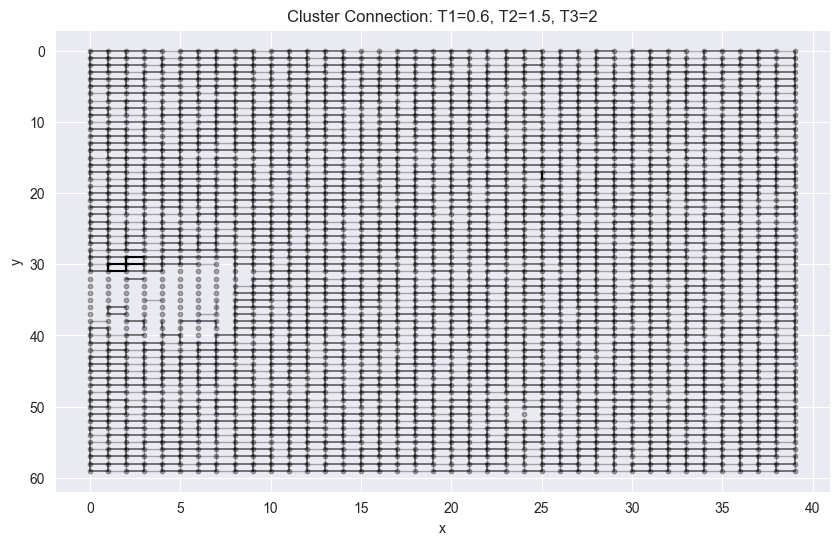

In [26]:
custom_cluster_connection(0.6, 1.5, 2)

The visualization highlights the global structure of the SOM, with most of the grid exhibiting strong and moderate connections, indicating well-defined clusters and transitions. The disconnected region stands out as a notable boundary or sparse area, where neighboring nodes are weakly related or dissimilar. This visualization effectively captures both the clustered and transitional aspects of the data.

### D-Matrix

A D-Matrix (Distance Matrix) is a visualization technique used in Self-Organizing Maps (SOMs) to represent the median distance between the weights of a node and its immediate neighbors. It provides a measure of how similar or dissimilar each node is to the surrounding nodes, making it a useful tool for identifying:
* **Clusters**: Regions with small median distances (low D-Matrix values) represent cohesive clusters where neighboring nodes are highly similar.
* **Cluster Boundaries**: Regions with large median distances (high D-Matrix values) indicate boundaries between clusters, where neighboring nodes are dissimilar.

In [27]:
def calculate_d_matrix(weights, m, n):
    d_matrix = np.zeros(m * n)
    for i in range(m):
        for j in range(n):
            p = i * n + j
            region = []
            if j > 0: region.append(p - 1)  # Left
            if i > 0: region.append(p - n)  # Up
            if j < n - 1: region.append(p + 1)  # Right
            if i < m - 1: region.append(p + n)  # Down
            d_matrix[p] = np.median(np.linalg.norm(weights[region] - weights[p], axis=-1))
    return d_matrix.reshape(m, n)

def custom_d_matrix():
    d_matrix = calculate_d_matrix(weights, m, n)
    plt.figure(figsize=(10, 6))
    plt.title("D-Matrix")
    plt.imshow(d_matrix, cmap="coolwarm", aspect="auto")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

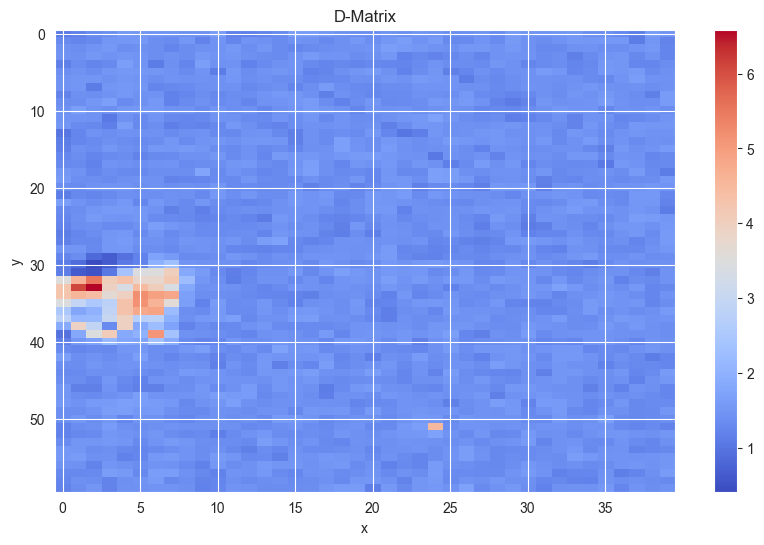

In [28]:
custom_d_matrix()

The D-Matrix highlights a cluster boundary with high D-Matrix values (red areas), indicating significant differences between neighboring nodes. Surrounding this, the dark blue areas show cluster cores, where nodes are highly similar. A smaller bright spot suggests an isolated node or a transition zone, potentially representing a unique pattern. The rest of the grid shows low, uniform values, reflecting a homogeneous structure with minimal boundaries or transitions. This visualization reveals a clear cluster, distinct boundaries, and potential anomalies in the dataset.

### U-Matrix

A U-Matrix (Unified Distance Matrix) is a visualization used to represent the distances between neighboring nodes in a SOM.

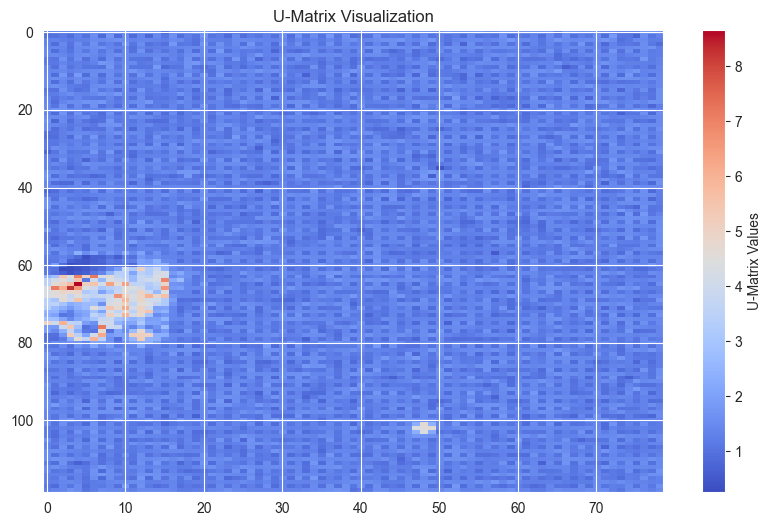

In [29]:
umatrix = som_vis._visualizations[2]
umatrix_data = umatrix.calculate_UMatrix(weights, m, n, som_vis._dim)
plt.figure(figsize=(10, 6))
plt.imshow(umatrix_data, cmap='coolwarm', aspect='auto')
plt.colorbar(label='U-Matrix Values')
plt.title('U-Matrix Visualization')
plt.show()

The U-Matrix reveals a distinct cluster, surrounded by boundaries where neighboring nodes are less similar. This suggests that the data in this area forms a cohesive group with a clear separation from other regions. An isolated region indicates a unique or rare pattern, potentially representing a transition zone or anomaly. The rest of the map shows minimal variation, reflecting a more homogeneous structure or underrepresented areas. Overall, the U-Matrix highlights a dominant cluster, well-defined boundaries, and a possible unique pattern in the dataset.

### U*-Matrix

The U-Star Matrix is a variant of the U-Matrix designed to enhance the visualization of local and global structures in the SOM. While the U-Matrix focuses on the average distances between neighboring nodes, the U-Star Matrix calculates the distance between each SOM node and all other nodes within a specified radius.

In [33]:
def calculate_u_matrix(weights, m, n, dim):
    U = weights.reshape(m, n, dim)
    U = np.insert(U, np.arange(1, n), values=0, axis=1)
    U = np.insert(U, np.arange(1, m), values=0, axis=0)
    for i in range(U.shape[0]):
        if i % 2 == 0:
            for j in range(1, U.shape[1], 2):
                U[i, j][0] = np.linalg.norm(U[i, j - 1] - U[i, j + 1], axis=-1)
        else:
            for j in range(U.shape[1]):
                if j % 2 == 0:
                    U[i, j][0] = np.linalg.norm(U[i - 1, j] - U[i + 1, j], axis=-1)
                else:
                    U[i, j][0] = (
                        np.linalg.norm(U[i - 1, j - 1] - U[i + 1, j + 1], axis=-1)
                        + np.linalg.norm(U[i + 1, j - 1] - U[i - 1, j + 1], axis=-1)
                    ) / (2 * np.sqrt(2))
    U = np.sum(U, axis=2)
    return U

def calculate_u_star_matrix(radius):
    distance = lambda v: np.sum(np.linalg.norm(input_data[:, None, :] - v, axis=-1) < radius)
    p_matrix = np.array([distance(v) for v in weights]).reshape(m, n)
    
    u_matrix = calculate_u_matrix(weights, m, n, weights.shape[1])
    u_matrix = u_matrix[::2, ::2].flatten()
    p_matrix_flat = p_matrix.flatten()
    mean_p = np.mean(p_matrix_flat)
    max_p = np.max(p_matrix_flat)
    diff = mean_p - max_p

    ustar_matrix = np.array([
        u_matrix[i] * ((p_matrix_flat[i] - mean_p) / diff + 1)
        for i in range(len(p_matrix_flat))
    ])
    return ustar_matrix.reshape(m, n)

def custom_u_star_matrix(radius, ax):
    u_star_data = calculate_u_star_matrix(radius)
    im = ax.imshow(u_star_data, cmap="coolwarm", aspect="auto")
    ax.set_title(f"U-Star Matrix (radius={radius})")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    return im

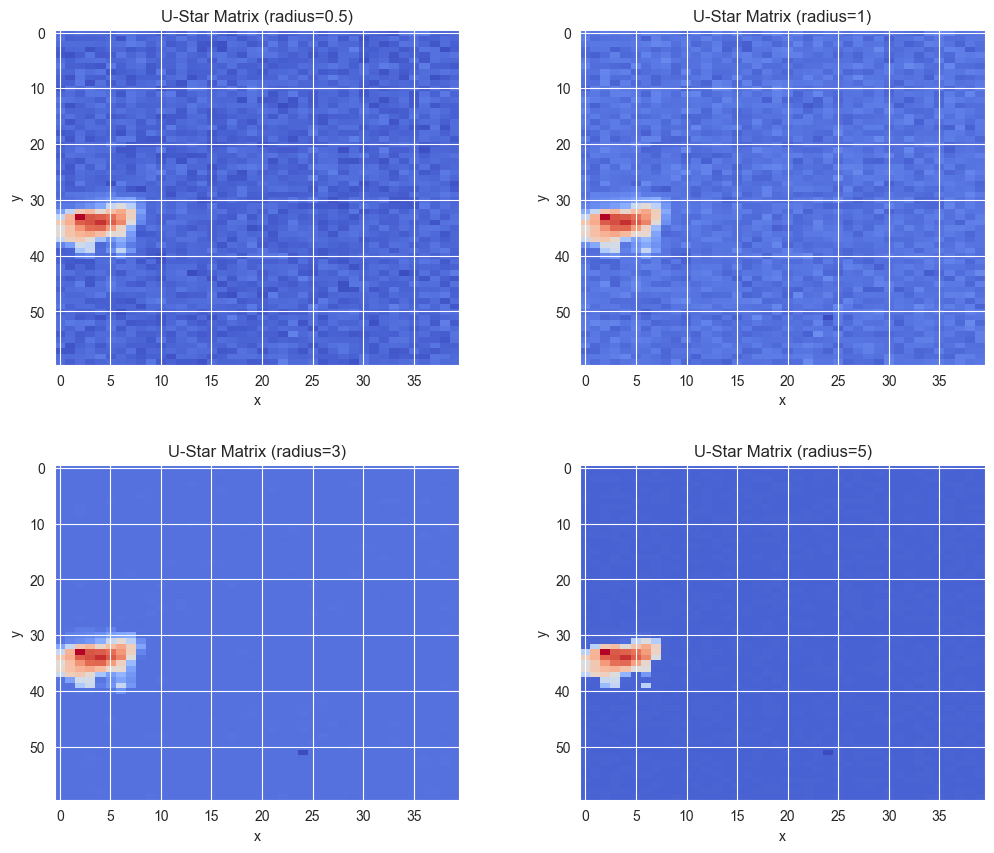

In [34]:
# Define radii
radii = [0.5, 1, 3, 5]

# Create a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

# Flatten axs array for easy iteration (since it's a 2x2 grid)
axs = axs.flatten()

# Plot each U-Star matrix on the grid
for ax, radius in zip(axs, radii):
    im = custom_u_star_matrix(radius, ax)

# Adjust layout to ensure proper spacing
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

The U-Star Matrix reveals a dominant cluster across all visualizations, with consistently low values indicating a dense grouping of similar nodes. As the radius increases, the boundaries of this cluster become more apparent, with higher values highlighting transitions to less similar nodes. This suggests a clear separation between the core of the cluster and its surrounding regions. The rest of the map remains largely uniform, with low values indicating sparse data representation or homogeneous patterns.

## Class Info

### Pie Chart

The Pie Chart Visualization for SOMs represents the distribution of different classes or groups across the nodes in the grid. Each SOM node is associated with a set of data points, and the pie charts visualize the proportion of each class present in the data mapped to that node.

In [35]:
def calculate_pie_chart_data(weights, input_data, classes, m, n, dim):
    grid = m * n
    n_classes = np.unique(classes)
    mapped_data = np.zeros((grid, len(n_classes)))

    bmu = np.apply_along_axis(
        lambda x: np.argmin(np.linalg.norm(weights - x.reshape((1, dim)), axis=1)),
        1,
        input_data,
    )

    for i in range(len(classes)):
        c = np.where(n_classes == classes[i])[0][0]
        u = bmu[i]
        mapped_data[u][c] += 1

    return mapped_data

classes = target.values

def custom_pie_chart(colors, class_labels):
    mapped_data = calculate_pie_chart_data(weights, input_data, classes, m, n, weights.shape[1])
    max_size = np.sum(mapped_data, axis=1).max()
    plt.figure(figsize=(10, 10))
    
    for i in range(m):
        for j in range(n):
            idx = i * n + j
            data = mapped_data[idx]
            total = data.sum()
            if total > 0:
                fractions = data / total
                sizes = fractions * (total / max_size) * 500
                center = (j, i)
                wedges, _ = plt.pie(
                    data,
                    radius=1 / max(m, n)*30,
                    colors=[colors[int(k)] for k in range(len(data))],
                    startangle=90,
                )
                plt.gca().add_artist(plt.Circle(center, 0.25, color="white", zorder=0))
                for w in wedges:
                    w.set_center(center)
    
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='None', label=label)
        for color, label in zip(colors, class_labels)
    ]
    plt.legend(handles=legend_handles, loc="upper right", bbox_to_anchor=(1.2, 1.0), title="Groups")
    

    plt.xlim(-0.5, n - 0.5)
    plt.ylim(-0.5, m - 0.5)
    #plt.xticks(range(n))
    #plt.yticks(range(m))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.title("Pie Chart")
    plt.show()

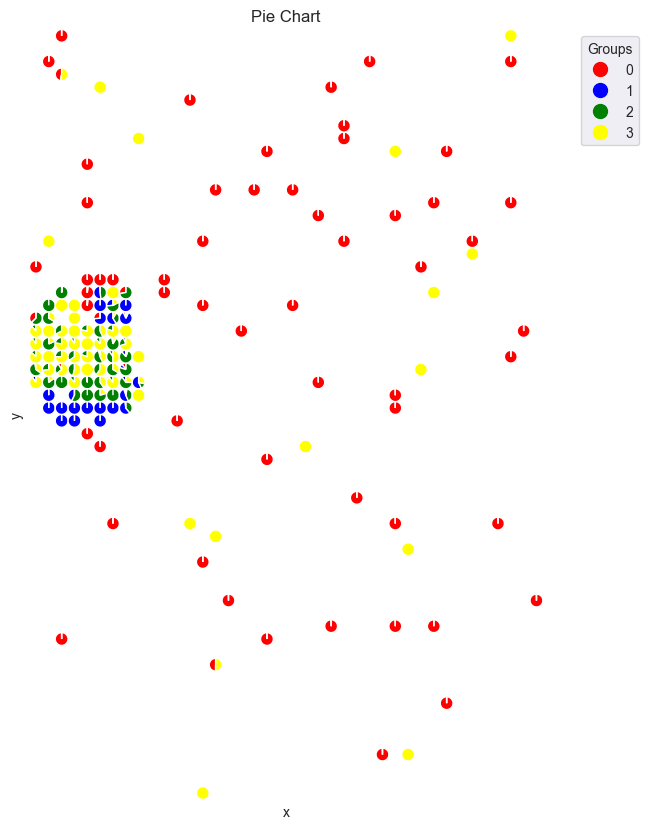

In [36]:
colors = ["red", "blue", "green", "yellow"]
custom_pie_chart(colors, np.unique(target))

The pie chart visualization reveals a dense cluster in the grid, where nodes contain data points from all four groups (`0`, `1`, `2`, and `3`). The multi-colored pie charts in this region indicate overlapping classes, with some nodes showing a mix of all groups and others dominated by specific groups, suggesting localized subclusters. Outside this dense area, the grid is sparser, with widely scattered nodes mostly dominated by a single class, represented by pure red (`0`), yellow (`3`). This distribution suggests that groups `0` and `3` are more widely distributed across the grid, while groups `1` and `2` are tightly clustered.

### Chessboard

The Chessboard Paths Visualization is designed to partition a feature space from a SOM into regions, where each region represents a distinct cluster, class, or group. It highlights decision boundaries or transitions between regions based on the underlying data patterns and relationships.

In [37]:
chessboard_plot = som_vis._visualizations[8]
chessboard_plot._calculate()
chessboard_plot_data = chessboard_plot._main._pipe.data

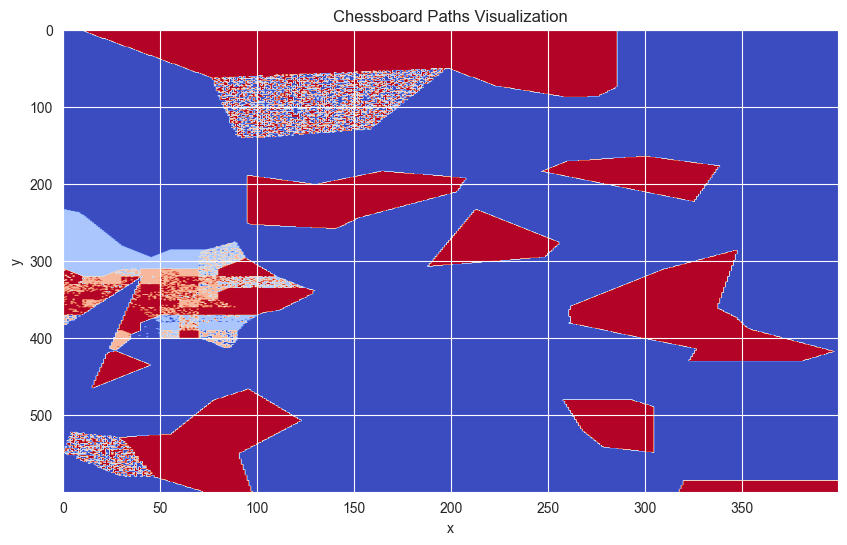

In [38]:
plt.figure(figsize=(10, 6))
plt.title("Chessboard Paths Visualization")
plt.imshow(chessboard_plot_data, cmap="coolwarm", aspect="auto")

plt.xlabel("x")
plt.ylabel("y")
plt.show()

The Chessboard Visualization divides the feature space into two main regions, represented by the pink and blue areas, which correspond to distinct clusters or groups. These regions dominate the grid and are separated by irregular boundaries, indicating nonlinear decision rules that adapt to the structure of the data. A dense and complex brown region appears, highlighting a transitional zone where patterns overlap or classes mix, suggesting less clear separability in this part of the data. The large, continuous pink and blue regions further from the center represent well-separated clusters, where the data points are homogeneous and belong to a single group without ambiguity. Overall, the visualization highlights a clear partitioning of the feature space with well-defined clusters and a complex central overlap zone.

## Attributes

### Component Planes

The Component Plane Visualization is used in SOMs to show how each individual feature (or component) is represented across the grid. Each plane corresponds to a single feature in the dataset and visualizes its activation levels or intensity values across the SOM nodes.

In [39]:
def custom_component_plane(component, ax):
    # Reshape component data into the 2D grid
    component_data = weights[:, component].reshape(m, n)
    
    # Plot component plane on the provided axis
    im = ax.imshow(component_data, cmap="coolwarm", aspect="auto")
    ax.set_title(f"Component {component}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    return im

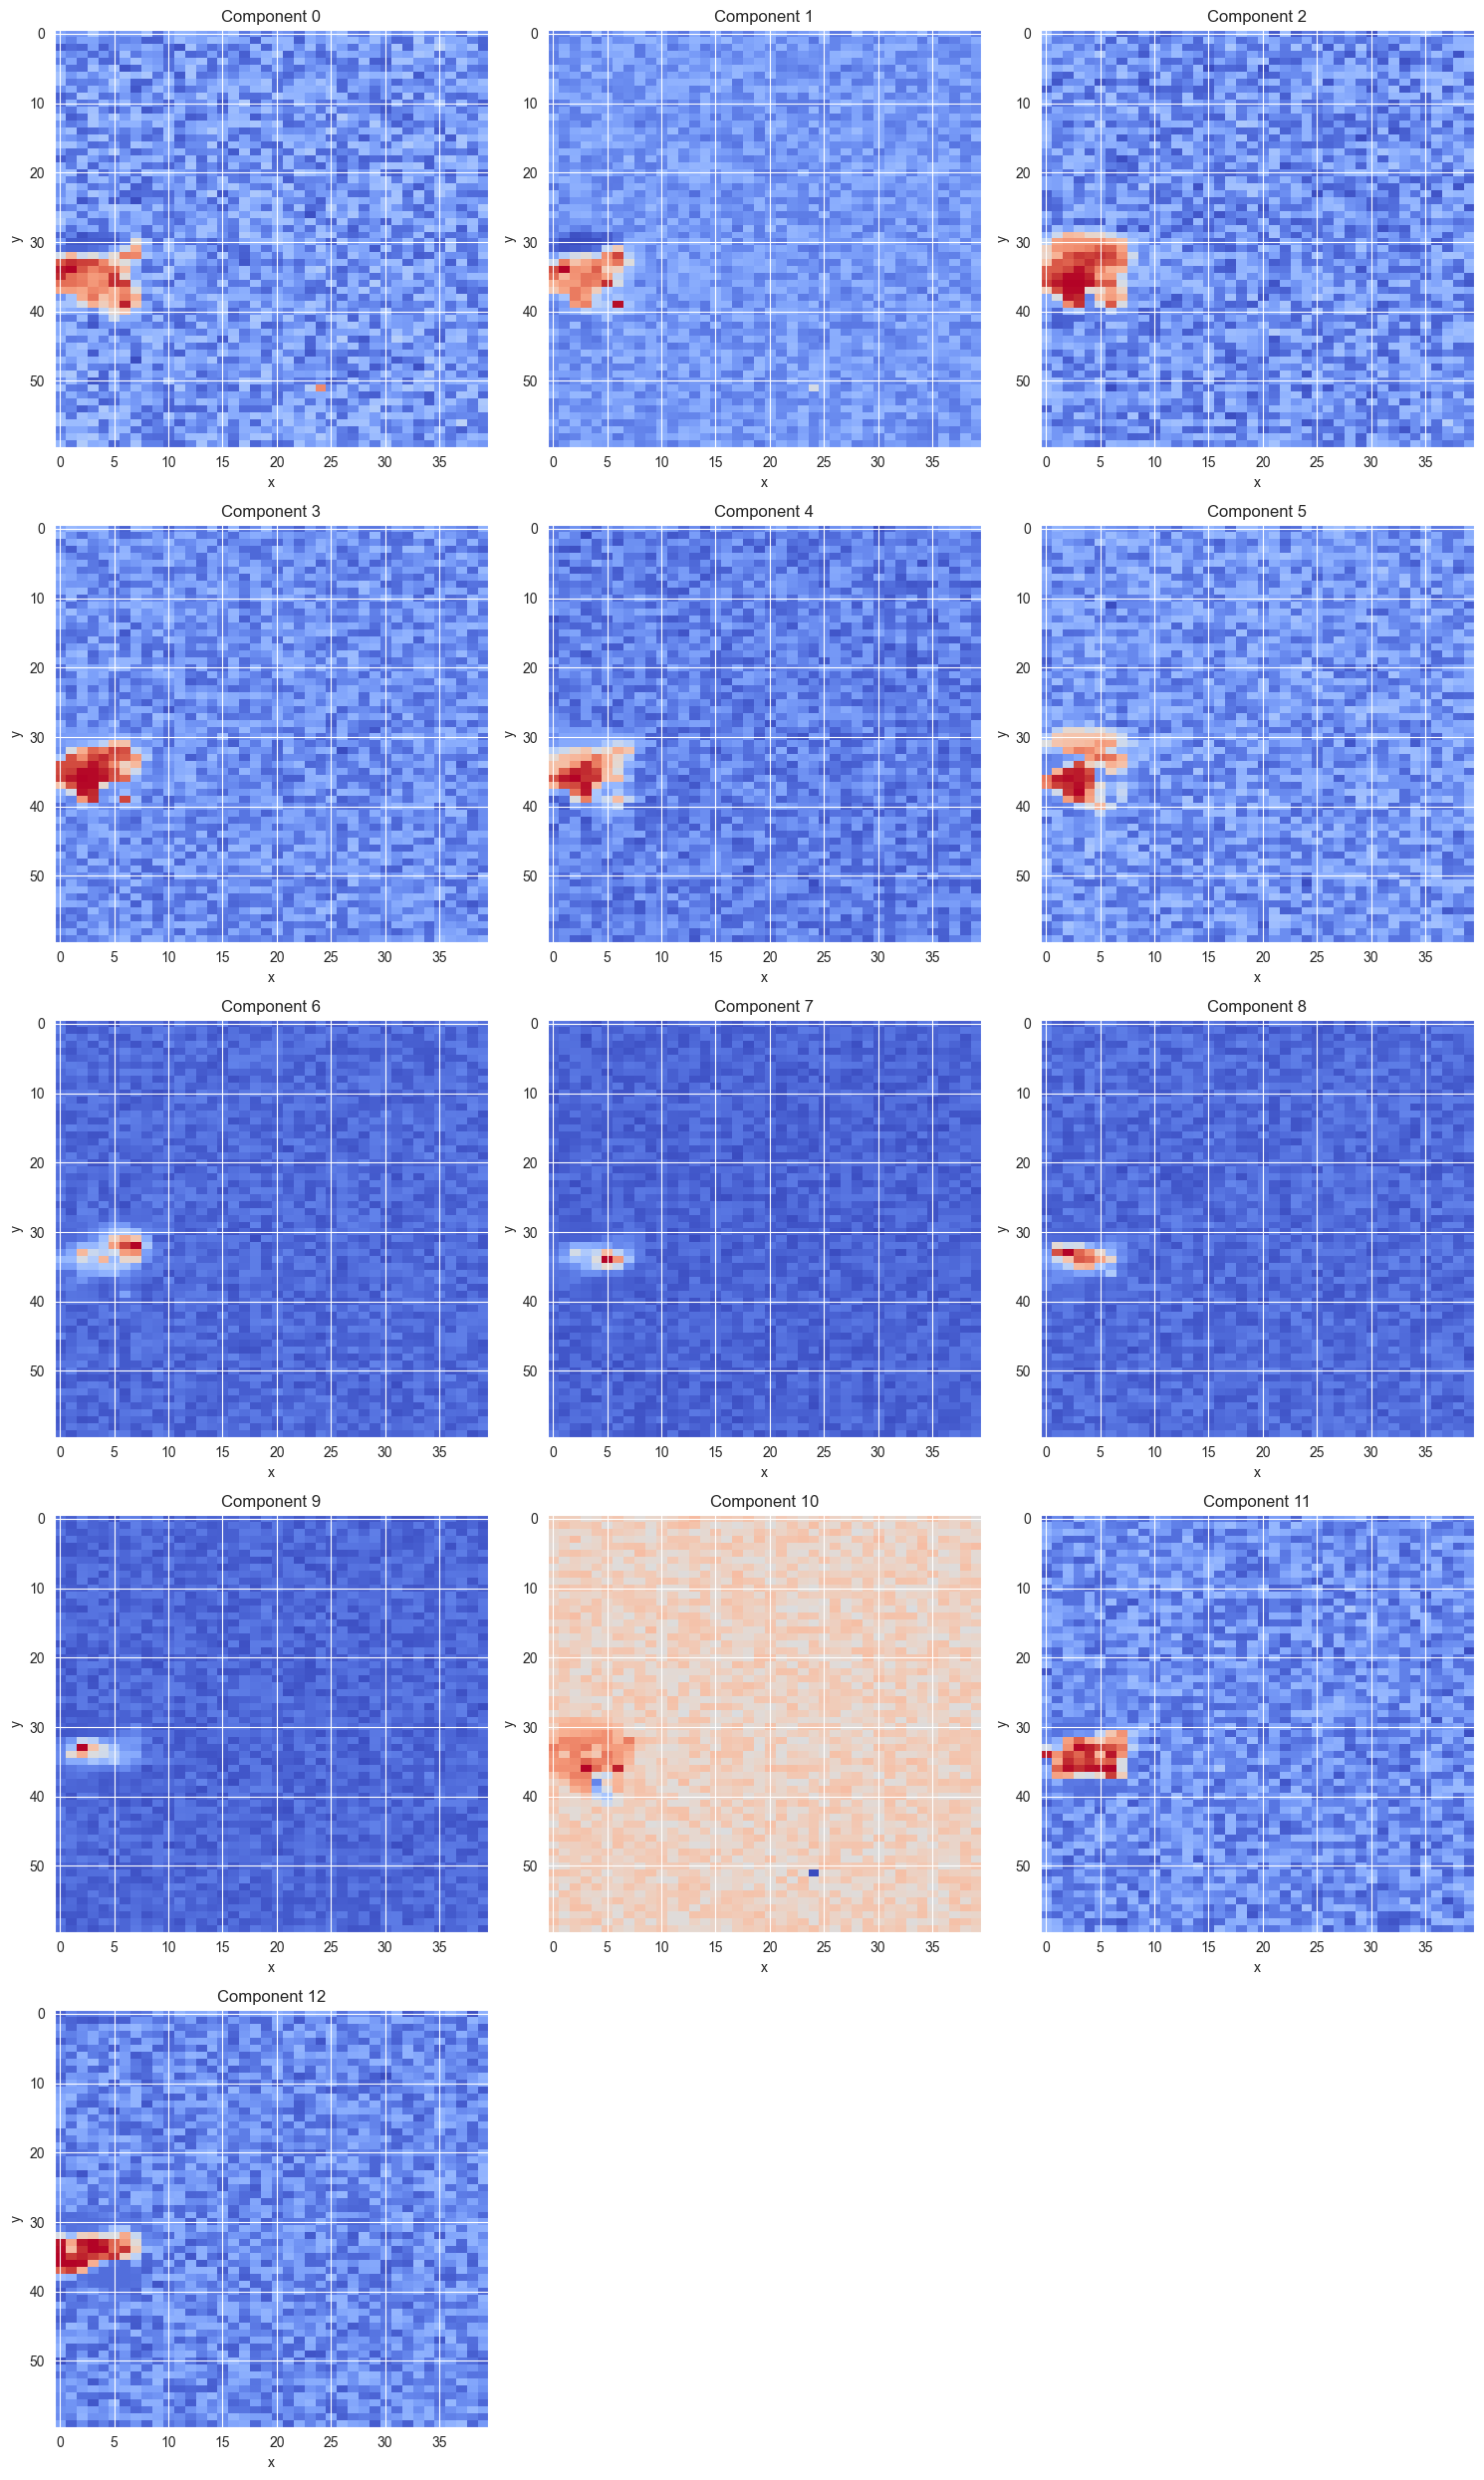

In [40]:
# Set up a grid of subplots
num_components = features_scaled_reduced.shape[1]
rows = (num_components + 2) // 3  # Choose 3 columns per row for better visibility
fig, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows))

# Flatten the axis array for easier iteration
axs = axs.flatten()

# Plot each component plane on the grid
for i in range(num_components):
    im = custom_component_plane(i, axs[i])

# Remove unused subplots (if any)
for j in range(num_components, len(axs)):
    axs[j].axis('off')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

The Component Plane visualizations for all features (0–12) consistently highlight a dominant cluster. This cluster is characterized by strong feature activations (red/orange regions) across multiple components, indicating that these features play a significant role in defining the cluster's structure. However, the extent and distribution of activation vary across components, revealing unique patterns for each feature.

Some components, such as Components 0–3, exhibit broader activation within the cluster, suggesting that these features influence larger portions of the data within the cluster. In contrast, other components, such as Components 6–9 and 10–12, show more localized and fragmented activation, indicating that these features are specialized and contribute to specific subclusters within the main cluster. For example, Component 10 highlights a distinct contrast with a small negative region (blue) adjacent to its high-intensity area, pointing to diverse feature values even within the same cluster.

Across the entire grid, low feature activations dominate outside the main cluster (blue regions), suggesting that most features are not prominent or relevant in these areas. This sparse representation outside the cluster implies that the SOM grid primarily captures the structure and relationships within the dominant cluster. Some components, such as 6 and 10, also highlight isolated spots with localized negative values, which may correspond to outliers or regions with unique feature characteristics.